In [26]:
from PIL import Image
import os, glob

#이미지 224x224에서 -> 28x28로 변환하기
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")


500  images to be resized.
500  images resized.
가위 이미지 resize 완료!
500  images to be resized.
500  images resized.
바위 이미지 resize 완료!
500  images to be resized.
500  images resized.
보 이미지 resize 완료!


In [27]:
#가위, 바위, 보 데이터를 읽을 수 있는 load_data() 함수 만들기
#load_data() 함수는 입력으로 이미지가 있는 폴더 위치를 받음
#가위바위보 -> 3개의 클래스 -> 가위 0, 바위 1, 보 2

import numpy as np

def load_data(img_path, number_of_data=1500):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화


학습데이터(x_train)의 이미지 개수는 1500 입니다.


라벨:  0


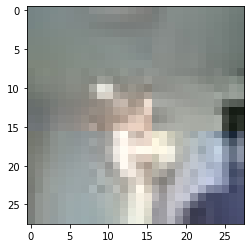

In [28]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [29]:
#딥러닝 네트워크 설계하기

import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow import keras

n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=30

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())

#첫번째 dsnse레이어의 첫번째 인자 : 클래스 3개니까, 16으로 바꿔야 하나...?
#16,32,64,128 바이트?의 단위 같은데, 뭘 의미하는지 모르겠어
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()



Model에 추가된 Layer 개수:  7
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_9 (Dense)              (

In [30]:
#딥러닝 네트워크 학습시키기
# Hint! model.compile()과 model.fit()을 사용해 봅시다.


model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

#정규화된 x_train값을 넣어야해서 norm으로 -> 근데 그냥 x_train으로 하면 다 0,1이 나옴 왜그럴까??
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

#과대적합 : 트레이닝 데이터, 테스트 데이터 > 학습시킨 데이터에 대한 모델로만 
#에포크를 너무 높였기 때문 (훈련데이터로만 계속 훈련을 하여서)
# <<- 정확도가 오르락 내리락하는게 과대 적합이라고 생각했는데, 아니였음 !!! 

#왜 정확도(accuracy)가 오르락 내리락 할까? : 경사 하강법(Gradient descent)을 통해서 loss를 줄이면서
#최적합 w값을 찾아가는 과정에 있어서 한번씩 값이 튀는 지점이 있기 때문 
#과녁의 이미지에서 에포크 한번 = 1번 학습하면서 과녁의 중앙=최적값으로 다가가는데, 그때 정확도 값이 오르락 내리락 하는 것 
#자세한 이해를 돕기위한 이미지 링크 : https://thebook.io/080228/part03/ch09/02/

#그럼 과적합 되었다는건 어떻게 아는걸까? > plot으로 그려보면 아는거 말고 있는지 모르겠음 (plot으로 그려보기)
#강민님꺼 보니까 처음부터 너무 높은 정확도가 나오면 오버피팅이라고 하시는것 같음 ! 
#그럼 정확도가 너무 가파르게 오르면 어떻게 되는걸까 ㅠㅠ

#그럼 오버피팅 해결방법
#1. 훈련 데이터를 더 많이 모음 
#2. 정규화(Regularization) - 규제(제약 조건), 드롭-아웃 등 다양한 방법을 이용해서 적당한 복잡도를 가지는 모델을 자동적으로 찾아주는 기법
#3. 훈련 데이터 잡음을 줄임(오류 수정과 이상치 제거)


Epoch 1/30
47/47 [==============================] - 1s 3ms/step - loss: 1.0768 - accuracy: 0.4298
Epoch 2/30
47/47 [==============================] - 0s 3ms/step - loss: 0.9106 - accuracy: 0.6155
Epoch 3/30
47/47 [==============================] - 0s 3ms/step - loss: 0.7144 - accuracy: 0.6721
Epoch 4/30
47/47 [==============================] - 0s 3ms/step - loss: 0.4939 - accuracy: 0.8233
Epoch 5/30
47/47 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.8995
Epoch 6/30
47/47 [==============================] - 0s 3ms/step - loss: 0.2614 - accuracy: 0.9334
Epoch 7/30
47/47 [==============================] - 0s 3ms/step - loss: 0.1968 - accuracy: 0.9443
Epoch 8/30
47/47 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9597
Epoch 9/30
47/47 [==============================] - 0s 3ms/step - loss: 0.1310 - accuracy: 0.9632
Epoch 10/30
47/47 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.9782
Epoch 11/30
47/47 [

## validation 검증

In [31]:
#validation
# 가위 이미지 28*28 이미지로 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation_set/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

# 바위 이미지 28*28 이미지로 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation_set/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지 28*28 이미지로 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation_set/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

101  images to be resized.
101  images resized.
가위 이미지 resize 완료!
101  images to be resized.
101  images resized.
바위 이미지 resize 완료!
101  images to be resized.
101  images resized.
보 이미지 resize 완료!


In [32]:
#이미지 불러오기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/validation_set/"
(x_val, y_val)=load_data(image_dir_path, 303)  
x_val_norm = x_val/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

학습데이터(x_train)의 이미지 개수는 303 입니다.
x_val shape: (303, 28, 28, 3)
y_val shape: (303,)


라벨:  0


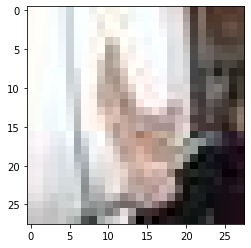

In [33]:
import matplotlib.pyplot as plt
plt.imshow(x_val[0])
print('라벨: ', y_val[0])

In [34]:
#딥러닝 네트워크 설계하기

import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow import keras

#channel : 정해진 값을 가진 건 아님, 
#1과2는 두배 간격이 좋음 (16,32가 정확도가 가장 높게 나옴. )
n_channel_1=16
n_channel_2=32
n_dense=32
n_val_epoch=30

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                25632     
_________________________________________________________________
dense_11 (Dense)             (

In [35]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_val_norm, y_val, epochs=n_val_epoch)


Epoch 1/30
10/10 [==============================] - 4s 408ms/step - loss: 1.0076 - accuracy: 0.3734
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.9459
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1839 - accuracy: 1.0000
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 1.0000
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 7/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 8/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 9/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 10/30
10/10 [==============================] - 0s 3ms/step - loss: 9.5718e-04 - accuracy: 1.0000
Epoch 11/30
1

## 테스트

In [36]:
#Test
# 가위 이미지 28*28 이미지로 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_set/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

# 바위 이미지 28*28 이미지로 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_set/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")


# 보 이미지 28*28 이미지로 변환
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_set/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

4  images to be resized.
4  images resized.
가위 이미지 resize 완료!
4  images to be resized.
4  images resized.
바위 이미지 resize 완료!
4  images to be resized.
4  images resized.
보 이미지 resize 완료!


In [37]:
#테스트 이미지 불러오기 #299개로 변환 ! 
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test_set/"
(x_test, y_test)=load_data(image_dir_path, 299)  
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 12 입니다.
x_test shape: (299, 28, 28, 3)
y_test shape: (299,)


라벨:  0


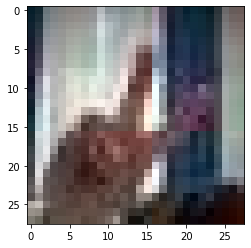

In [38]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

In [39]:
#딥러닝 네트워크 설계하기

import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow import keras

#channel : 정해진 값을 가진 건 아님, 
#1과2는 두배 간격이 좋음 (16,32가 정확도가 가장 높게 나옴. )
n_channel_1=16
n_channel_2=32
n_dense=32
n_test_epoch=30

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                25632     
_________________________________________________________________
dense_13 (Dense)             (

In [40]:
#모델학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_test_norm, y_test, epochs=n_test_epoch)

Epoch 1/30
10/10 [==============================] - 0s 3ms/step - loss: 1.0976 - accuracy: 0.6658
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 1.0437 - accuracy: 0.9767
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.8924 - accuracy: 0.9760
Epoch 4/30
10/10 [==============================] - 0s 4ms/step - loss: 0.5575 - accuracy: 0.9748
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1806 - accuracy: 0.9856
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0558 - accuracy: 0.9844
Epoch 7/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0367 - accuracy: 0.9808
Epoch 8/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0337 - accuracy: 0.9913
Epoch 9/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0388 - accuracy: 0.9892
Epoch 10/30
10/10 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9904
Epoch 11/30
10/10 [

In [41]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.0029 - accuracy: 1.0000
test_loss: 0.0028607321437448263 
test_accuracy: 1.0
